In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import h5py
import quimb as qu
from pathlib import Path
from matplotlib.colors import LogNorm

from itertools import product
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import MultiStepLR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lda.ml.classes import MLLP
from lda.utils import print_comparison, create_basis, experimental_data
from lda.ml.sfw.optimizers import Adam
from lda.ml.core import train
from lda.ml.utils import calculate_error, load_data

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'text.latex.preamble': r'\usepackage{bbm}'
})

%load_ext autoreload
%autoreload 2

/home/user/miniconda3/envs/lda/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/home/user/lda/src/lda/ml/sfw/constraints.py:385: SyntaxWarning: invalid escape sequence '\i'
  # Polytopes with vertices v \in {0, +/- r}^n such that exactly k entries are nonzero


# Training of Lindblad Dynamycs Approximator

In this notebook we train and test the LDA on data coming from TEBD simulations.

# Sample the data
We first create the synthetic experimental data by sampling the TEBD data.

This can be skipped and use directly the data save in ./data/data_tebd_sampled.hdf5

NOTE: the following cell must be executed even though the dat is not created

In [2]:
prms = {'L': 50,         # length of the
        'V': 0.1,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

In [3]:
### CREATE - training set
exp_data = {'X' : [],
            'y' : [],
            't' : []}

# import the exact dynamics
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]
    
t = np.arange(0, prms['T'], prms['dt'])
    
for n in range(prms['num_traj']):
    v_0 = data_tebd[1000*n]
    
    # select some random times at which to sample
    indeces = np.random.choice(range(1, len(t)), prms['M'], replace=False)
    for i in indeces:
        # same initial conditions and time
        exp_data['X'].append(v_0)
        exp_data['t'].append(t[i])
        # the data
        exp_data['y'].append( experimental_data(data_tebd[1000*n+i], N=prms['N']))
        
### SAVE
gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))

with h5py.File('./data/data_tebd_sampled.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/X']
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('X', data=exp_data['X'])
    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

## Train the model

Here we train the model.

Some specifications:
- for the case of a weakly interacting chain $V=0.1$ we start with a lr = $0.01$, then gamma = $0.1$
- for the case of strongly interacting chain $V=2$ we start with a lr = $0.05$, then gamma = $0.05$

In [4]:
def train_model(data_dir, ML_params, PRMS):
    # load the data
    train_loader, eval_loader = load_data(data_dir, PRMS['L'],
                                          PRMS['V'], PRMS['N'], PRMS['M'], PRMS['num_traj'], 
                                          ML_params['batch_size'],
                                          ML_params['validation_split'])
    # create the model
    model = MLLP(ML_params['mlp_params']).to(ML_params['device'])

    criterion = torch.nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    scheduler = MultiStepLR(optimizer, milestones=[300, 350], gamma=0.05)

    # train the model
    loss = train(model, criterion, optimizer, scheduler, train_loader,
                ML_params['n_epochs'], ML_params['device'],
                alpha_1=[1e-4,0], alpha_2=[])

    # name the model
    name = 'model_' + str(PRMS['L']) + \
            '_V_' + str(int(PRMS['V']*1e3)).zfill(4) + \
            '_N_' + str(int(PRMS['N'])) + '_M_' + str(int(PRMS['M']))
    # save the model
    torch.save(model.state_dict(), ML_params['model_dir'] + name)

    plt.plot([i for i in range(1, ML_params['n_epochs']+1)], loss)
    plt.yscale('log')
    plt.grid()

Data points used in the training 750
= Starting epoch  1 / 400
=== Mean train loss: 0.057716917247
=== lr: 0.05000
= Starting epoch  2 / 400
=== Mean train loss: 0.057276029140
=== lr: 0.05000
= Starting epoch  3 / 400
=== Mean train loss: 0.055841065943
=== lr: 0.05000
= Starting epoch  4 / 400
=== Mean train loss: 0.055117948602
=== lr: 0.05000
= Starting epoch  5 / 400
=== Mean train loss: 0.053633941958
=== lr: 0.05000
= Starting epoch  6 / 400
=== Mean train loss: 0.050289212416
=== lr: 0.05000
= Starting epoch  7 / 400
=== Mean train loss: 0.042227026075
=== lr: 0.05000
= Starting epoch  8 / 400
=== Mean train loss: 0.033860478550
=== lr: 0.05000
= Starting epoch  9 / 400
=== Mean train loss: 0.027029112602
=== lr: 0.05000
= Starting epoch  10 / 400
=== Mean train loss: 0.024063369880
=== lr: 0.05000
= Starting epoch  11 / 400
=== Mean train loss: 0.023847466335
=== lr: 0.05000
= Starting epoch  12 / 400
=== Mean train loss: 0.022550558050
=== lr: 0.05000
= Starting epoch  13 / 4

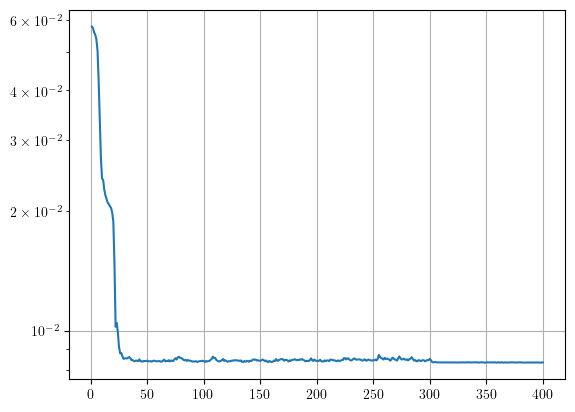

In [5]:
## select the specifications for the training 
ml_params = {'model_dir': './data/trained/',  # folder to store the metadata of the ML model
             'validation_split': 0,
             'batch_size': 256,
             'time_dependent': False,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }
prms = {'L': 50,         # length of the
        'V': 0.1,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

# single train
train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

# training loop
#for nn in [15,20,25]:
#    for mm in [1,2,3,4,5,10,15,20,25]:
#        prms['N'] = nn
#        prms['M'] = mm
#        print("\n==============================")
#        print(f'N = {nn} M = {mm}')
#        train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

## Performance of the model

In [6]:
# load the model
name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)))

<All keys matched successfully>

In [7]:
# import test data
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

In [8]:
# calculate the average error
errors = np.zeros(10)
for i in range(10):
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10)    
    errors[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:1000*(i+1)], T=10, dt=0.01)
print(errors.mean())

0.009835685197850441


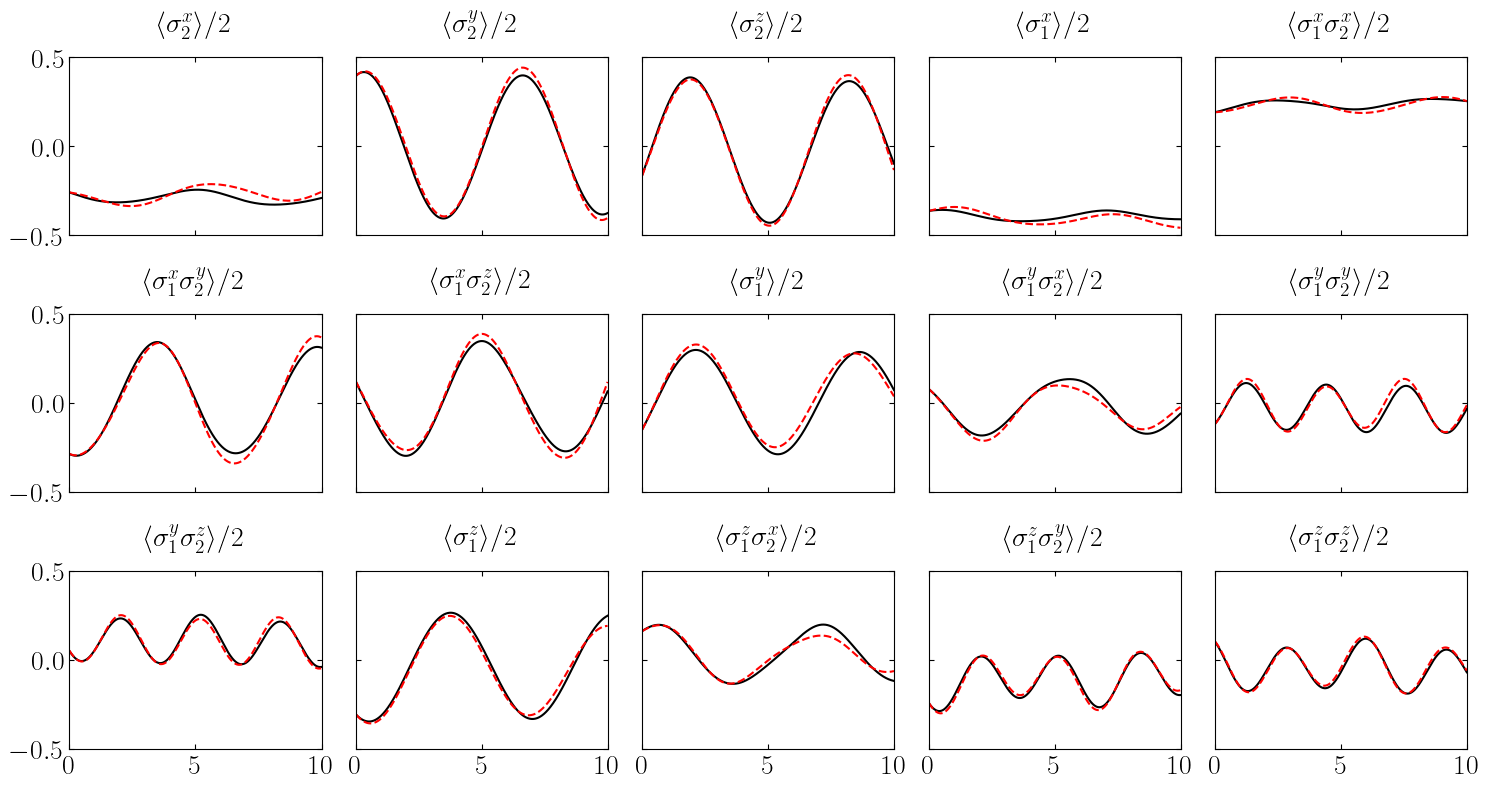

In [9]:
# select the test data to compare with, indx \in [1,10]
indx = 3
# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_test[indx*1000]), T=10)    
print_comparison(data_test[indx*1000:(indx*1000 +1000)], ml_dyn, 10, dt=0.01, ylim=0.5)

## Full plot

Here we plot the full grid comparing the model for each combination (N,M)

In [10]:
prms = {'L': 50,         # length of the
        'V': 2,        # magnitude of the interaction
        'T': 10,         # time window of the evolution
        'T_test': 20,    # time window to test the model
        'dt': 0.01,      # interval of sampling time
        'num_traj': 30,  # number of trajectories for each combinations of params
        'N' : 25,        # number of samples for each point in time
        'M' : 25         # number of times for trajcetory
       }

In [11]:
# for each combinations of N and M I calculate the error, averaged over 10 trajectories
N = [1,2,3,4,5,10,15,20,25]
M = [1,2,3,4,5,10,15,20,25]

errors = []

# import test data
gname =  'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

for m in M:
    err = []
    for n in N:
        # name the model
        name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(n) + '_M_' + str(m)
        
        # import the model
        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))
        
        # calculate error
        errs = np.zeros(10)
        for i in range(10):
            ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10)    
            errs[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:1000*(i+1)], T=10, dt=0.01)
    
        err.append(errs.mean())
    errors.append(err)

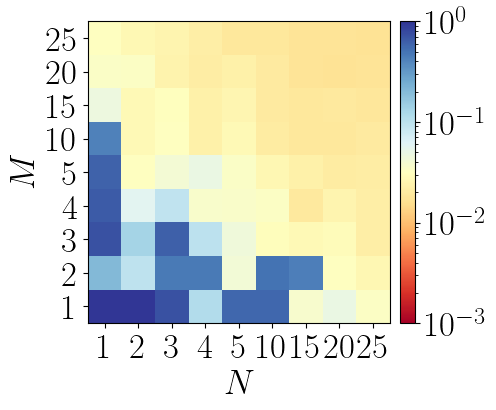

In [15]:
fig, ax = plt.subplots(dpi=100)

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(['$'+str(i)+'$' for i in my_x_ticks])
ax.set_xlabel(r'$N$', fontsize=25)
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(['$'+str(i)+'$' for i in my_y_ticks])
ax.set_ylabel(r'$M$', fontsize=25)

ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=25)

plt.show()
#fig.savefig('./plots/V_05.pdf', dpi=150, bbox_inches='tight')

# Explicit expression

Here we briefly show how to extract the expressions for the Hamiltonian and the dissipator.

basis = [IX, IY, IZ, XI, XX, XY, XZ, YI, YX, YY, YZ, ZI, ZX, ZY, ZZ]

In [12]:
basis = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

# select the model to look at
prms['V'] = 0.1
prms['N'] = 20
prms['M'] = 20

name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)));

### Hamiltonian

In [13]:
H = 0.5*model.MLP.omega.detach().numpy().round(2)

hamiltonian = dict(zip(basis,H))
dict(sorted(hamiltonian.items(), key=lambda item: abs(item[1])))

{'XX': np.float32(-0.0),
 'YY': np.float32(0.0),
 'YZ': np.float32(0.0),
 'XY': np.float32(0.005),
 'XZ': np.float32(-0.005),
 'YX': np.float32(-0.005),
 'ZX': np.float32(-0.005),
 'ZY': np.float32(0.005),
 'ZZ': np.float32(0.025),
 'IY': np.float32(-0.03),
 'YI': np.float32(-0.03),
 'IZ': np.float32(0.055),
 'ZI': np.float32(0.055),
 'IX': np.float32(0.5),
 'XI': np.float32(0.5)}

### Dissipator

In [14]:
v_x = model.MLP.v_x
v_y = model.MLP.v_y
c_re = torch.add(torch.einsum('ki,kj->ij', v_x, v_x),\
                torch.einsum('ki,kj->ij', v_y, v_y)  )
c_im = torch.add(torch.einsum('ki,kj->ij', v_x, v_y),\
                -torch.einsum('ki,kj->ij', v_y, v_x) )

koss = (c_re + 1j*c_im).detach().numpy()

In [15]:
e_val, e_vec = np.linalg.eig(koss)

In [16]:
e_val.round(3)

array([ 0.013+0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j,  0.   +0.j,
        0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   +0.j,
        0.   -0.j, -0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j],
      dtype=complex64)

In [17]:
# indx selects which channel to look at, in this case we look at indx=0, the only one
# with a non-zero decay rate
indx = 0
L = 0.5*e_vec[indx].round(2)

jump = dict(zip(basis, L))
dict(sorted(jump.items(), key=lambda item: abs(item[1])))

{'IX': np.complex64(-0+0j),
 'IZ': np.complex64(0.005+0j),
 'YZ': np.complex64(0.02+0.035j),
 'ZZ': np.complex64(-0.03+0.06j),
 'ZX': np.complex64(0.005+0.08j),
 'ZI': np.complex64(-0.09+0.02j),
 'ZY': np.complex64(0.03-0.1j),
 'XX': np.complex64(0.09-0.065j),
 'XI': np.complex64(-0.05-0.105j),
 'YX': np.complex64(-0.09-0.08j),
 'YI': np.complex64(0.095-0.075j),
 'YY': np.complex64(0.055+0.145j),
 'XY': np.complex64(-0.16+0.07j),
 'IY': np.complex64(0.19-0.1j),
 'XZ': np.complex64(0.245+0j)}